# Sound Classification for the Deaf

Sound is essential in the daily lives of all living organisms. It tells us about the environment, its characteristics, people, places, and movements in ways that visuals cannot. In today's world, various types of sound are present in the environment, and it is necessary to classify useful sounds and noise. The various types of sounds produced in urban areas are considered for classification. This classified sound can be especially useful for hearing-impaired people who need to identify different types of sounds and react appropriately. The majority of hearing loss is caused by inner ear or nerve damage. A variety of factors cause the damage. It could be due to congenital defects, diseases, injury, exposure to loud noise for a long period of time, and age-related wear and tear. Among the above-stated reasons, only a few cases can be resolved using the Hearing Aid. The rest have to live with the defect, as there hasn’t been any significant improvement in this field. Thus the proposed Sound Classification for Hearing Impaired people can help classify the different sounds and stay connected to the happenings of the environment. 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cd /content/drive/MyDrive/Datasets/Deep_Learning

### Import the Libraries

In [4]:
import matplotlib.pyplot as plt
#for loading and visualizing audio files
import librosa
import librosa.display
from tqdm import tqdm
#To play audio
import IPython.display as ipd
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import keras
from keras.models import Sequential, Model,load_model
from tensorflow.keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers import Input, Dense, Dropout, LSTM, Embedding, Flatten, Bidirectional, BatchNormalization
from keras.preprocessing import image
from keras.initializers import glorot_uniform
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau
import os
import shutil

In [5]:
label_csv = '/content/drive/MyDrive/Datasets/Deep_Learning/esc50.csv'
audio_fpath = "/content/drive/MyDrive/Datasets/Deep_Learning/audio/"

### Make a fucntion to perform Audio Augmentation


*   Add Noise
*   Shift Audio
*   Stretch Audio



In [6]:
class AudioAugmentation:
    
    def read_audio_file(self, file_path):
        input_length = 220500
        data = librosa.load(file_path)[0]
        if len(data) > input_length:
            data = data[:input_length]
        else:
            data = np.pad(data, (0, max(0, input_length - len(data))), "constant")
        return data
    
    def add_noise(self, data):
        noise = np.random.randn(len(data))
        data_noise = data + 0.005 * noise
        return data_noise
    
    def shift(self, data):
        return np.roll(data, 22050)
    
    def stretch(self, data, rate=1):
        input_length = 220500
        data = librosa.effects.time_stretch(data, rate)
        if len(data) > input_length:
            data = data[:input_length]
        else:
            data = np.pad(data, (0, max(0, input_length - len(data))), "constant")
        return data

    def write_audio_file(self, file, data, sample_rate=44100):
        librosa.output.write_wav(file, data, sample_rate)

### Converting WAV audio to Mel spectrograms

In [7]:
def create_dir(dirname):
    if os.path.exists(dirname):
        pass
    else:
        os.makedirs(dirname)
        
def wav2mel(path, clip, output, sample_rate=44100):
    x, sr = librosa.load(path+clip, sr=sample_rate)
    sgram=librosa.stft(x)
    sgram_mag, _ = librosa.magphase(sgram)
    
    mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=sr)
    mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
    librosa.display.specshow(mel_sgram, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.savefig(output)
    plt.clf()

In [8]:
audio_clips = os.listdir(audio_fpath)
print("No. of .wav files in audio folder = ",len(audio_clips))
df = pd.read_csv(label_csv)

print(df.head())
df.shape

No. of .wav files in audio folder =  2002
            filename  fold  target        category  esc10  src_file take
0   1-100032-A-0.wav     1       0             dog   True    100032    A
1  1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2  1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3  1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4  1-101296-A-19.wav     1      19    thunderstorm  False    101296    A


(2000, 7)

In [9]:
x, sr = librosa.load(audio_fpath+audio_clips[0], sr=44100)
print(type(x), type(sr))
print(x.shape, sr)

<class 'numpy.ndarray'> <class 'int'>
(220500,) 44100


In [10]:
feature = librosa.feature.mfcc(y=x, sr = 44100)
print(feature.shape)

(20, 431)


In [12]:
aa = AudioAugmentation()
extracted_data = []
for index, row in tqdm(df.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_fpath),str(row["filename"]))
    class_labels = row['category']
    y, sr = librosa.load(file_name, sr=44100)
    for i in range(8):
        if i == 1 or i >3:
            y = aa.add_noise(y)
        if i%3 == 2 or i == 7:
            y = aa.shift(y)
        if i%3 == 0 or i == 7:
            y = aa.stretch(y, rate=1.25)
        feature = librosa.feature.mfcc(y=y, sr=sr)
        scaled_feature = np.mean(feature.T,axis=0)
        extracted_data.append([scaled_feature, class_labels])
np.array(extracted_data).shape

2000it [27:48,  1.20it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(16000, 2)

In [13]:
feature_df = pd.DataFrame(extracted_data, columns=['feature','class'])

print(feature_df.head())

                                             feature class
0  [-632.056, 6.9280477, -5.63157, -3.5181608, -2...   dog
1  [-347.0140501621845, -2.3466943466216255, -3.4...   dog
2  [-346.99730532163295, -2.3201645024259503, -3....   dog
3  [-444.0913414305589, -2.4582368844355416, -3.2...   dog
4  [-334.505736931939, -3.838682366879073, -3.241...   dog


In [14]:
x = np.array(feature_df['feature'].tolist())

x.shape

(16000, 20)

In [15]:
target = np.array(feature_df['class'].tolist())

In [16]:
y_new = pd.get_dummies(target)
print(y_new.shape)
y_new.head()

(16000, 50)


,airplane,breathing,brushing_teeth,can_opening,car_horn,cat,chainsaw,chirping_birds,church_bells,clapping,...,siren,sneezing,snoring,thunderstorm,toilet_flush,train,vacuum_cleaner,washing_machine,water_drops,wind
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Train Test Split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(x, y_new, test_size=0.1, random_state=15)
print(str(X_train.shape)+ ', ' + str(X_test.shape))
inp = (1, 20)
np.array(X_train).reshape(14400, 1, 20)

(14400, 20), (1600, 20)


array([[[-2.68931702e+02,  1.08840683e+02, -2.64278297e+01, ...,
         -2.29460672e-01,  1.59656227e+00, -1.96956539e+00]],

       [[-1.97485795e+02,  4.95122940e+01, -3.69908317e+01, ...,
         -9.09766974e-01,  7.34863632e+00,  5.75032249e-01]],

       [[-4.34523947e+02, -2.66062053e+00, -2.51423299e+00, ...,
          8.16617681e-01,  2.08738926e-01, -2.65217355e-01]],

       ...,

       [[-3.05396967e+02,  1.41219500e+01, -8.39233621e+00, ...,
          6.36336461e+00,  7.85116085e+00,  4.99926772e+00]],

       [[-2.85572299e+02,  1.97179076e+01,  5.38035463e+00, ...,
          3.21608591e-01,  2.15903958e+00,  4.27415025e+00]],

       [[-6.11604065e+02,  7.95887222e+01,  1.48437929e+00, ...,
          1.41405433e-01,  6.48340082e+00, -2.98140585e-01]]])

In [18]:
np.array(X_train).reshape(14400,1,20)

array([[[-2.68931702e+02,  1.08840683e+02, -2.64278297e+01, ...,
         -2.29460672e-01,  1.59656227e+00, -1.96956539e+00]],

       [[-1.97485795e+02,  4.95122940e+01, -3.69908317e+01, ...,
         -9.09766974e-01,  7.34863632e+00,  5.75032249e-01]],

       [[-4.34523947e+02, -2.66062053e+00, -2.51423299e+00, ...,
          8.16617681e-01,  2.08738926e-01, -2.65217355e-01]],

       ...,

       [[-3.05396967e+02,  1.41219500e+01, -8.39233621e+00, ...,
          6.36336461e+00,  7.85116085e+00,  4.99926772e+00]],

       [[-2.85572299e+02,  1.97179076e+01,  5.38035463e+00, ...,
          3.21608591e-01,  2.15903958e+00,  4.27415025e+00]],

       [[-6.11604065e+02,  7.95887222e+01,  1.48437929e+00, ...,
          1.41405433e-01,  6.48340082e+00, -2.98140585e-01]]])

### Perform Train-Test Split

In [21]:
model = Sequential()
model.add(Input(shape = (1,20)))
model.add(Bidirectional(LSTM(1024, return_sequences = True, recurrent_dropout = 0.1)))
model.add(Flatten())
# Gave a Testing accuracy of 75 so removing the following two layers
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(Dense(50, activation='softmax'))
adam = tf.keras.optimizers.Adam(learning_rate=0.002)
model.compile(loss = 'categorical_crossentropy',
                  optimizer=adam,
                  metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 1, 2048)          8560640   
 nal)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 50)                102450    
                                                                 
Total params: 8,663,090
Trainable params: 8,663,090
Non-trainable params: 0
_________________________________________________________________
None


### Compile and Fit the Model

In [22]:
es = EarlyStopping(
    monitor='val_accuracy', 
    restore_best_weights=True, 
    patience=30, min_delta = 0.001
)
lrr = ReduceLROnPlateau(monitor='val_accuracy', 
                        patience=3, 
                        verbose=1, 
                        factor=0.5,
                        min_lr=0.00001)

history=model.fit(np.array(X_train).reshape(14400, 1, 20),
        np.array(y_train),
        epochs=500,
        callbacks = [lrr],
        batch_size = 100,
        validation_data = (np.array(X_test).reshape(1600,1,20),
                            np.array(y_test))
                           )

Epoch 1/500
144/144 [==============================] - 5s 15ms/step - loss: 2.8771 - accuracy: 0.2212 - val_loss: 2.5077 - val_accuracy: 0.2800 - lr: 0.0020
Epoch 2/500
144/144 [==============================] - 2s 13ms/step - loss: 2.3048 - accuracy: 0.3505 - val_loss: 2.1567 - val_accuracy: 0.3837 - lr: 0.0020
Epoch 3/500
144/144 [==============================] - 2s 14ms/step - loss: 2.0091 - accuracy: 0.4244 - val_loss: 1.9971 - val_accuracy: 0.4325 - lr: 0.0020
Epoch 4/500
144/144 [==============================] - 2s 15ms/step - loss: 1.8031 - accuracy: 0.4839 - val_loss: 1.8982 - val_accuracy: 0.4519 - lr: 0.0020
Epoch 5/500
144/144 [==============================] - 1s 9ms/step - loss: 1.6364 - accuracy: 0.5351 - val_loss: 1.7414 - val_accuracy: 0.4938 - lr: 0.0020
Epoch 6/500
144/144 [==============================] - 1s 9ms/step - loss: 1.4907 - accuracy: 0.5763 - val_loss: 1.5721 - val_accuracy: 0.5400 - lr: 0.0020
Epoch 7/500
144/144 [==============================] - 1s 9m

### Plotting Model Accuracy

Text(0, 0.5, 'Accuracy')

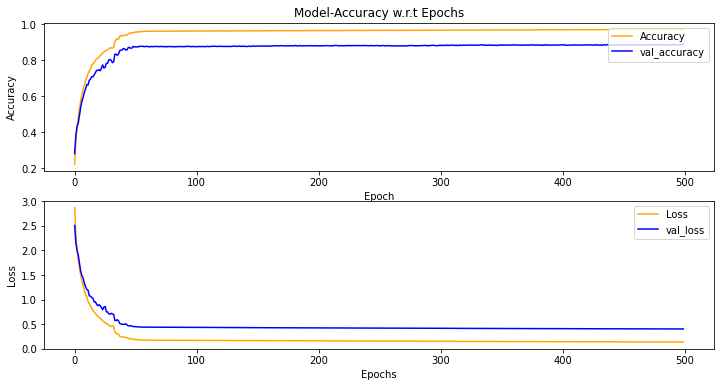

In [23]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,6))
ax2.plot(history.history['loss'], color='orange', label='Loss')
ax2.plot(history.history['val_loss'], color='blue', label='val_loss')
ax2.legend(loc='upper right')
ax1.plot(history.history['accuracy'], label='Accuracy', color='orange')
ax1.plot(history.history['val_accuracy'], label='val_accuracy', color='blue')
ax1.legend(loc="upper right")
ax1.set_title("Model-Accuracy w.r.t Epochs", loc='center')
plt.xlabel("Epochs")
plt.ylabel("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")

In [24]:
y_pred = model.predict(np.array(X_test).reshape(1600, 1,20))

50/50 [==============================] - 1s 3ms/step


In [25]:
y_pred_classes = np.argmax(y_pred, axis=1)

In [26]:
y_pred_classes

array([36, 39, 39, ..., 41,  2, 14])